Read 12 event windows from Max_per_month/Variation_Positive_secondary.csv.
Average trajectory computed:
   relative_position   variation
0                 -3 -714.580833
1                 -2 -490.699167
2                 -1 -541.280833
3                  0    0.000000
4                  1 -609.181667
5                  2 -661.136667
6                  3 -647.099167


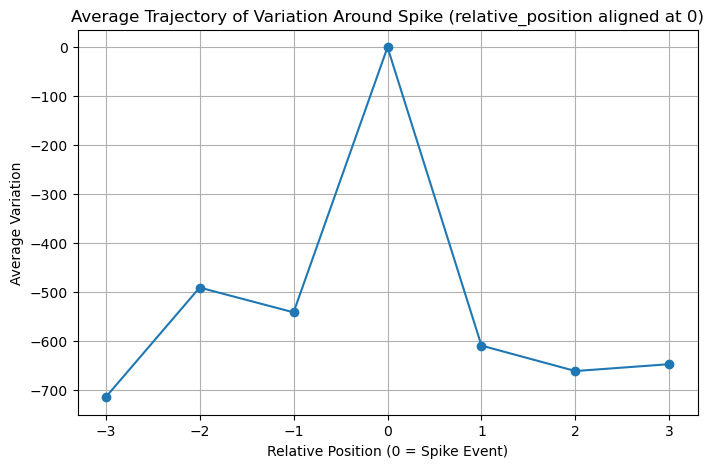

c:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Extracted features with cluster assignments:
    spike_variation  mean_before   mean_after  cluster
0               0.0  -738.130000  -978.606667        0
1               0.0  -669.040000  -434.823333        1
2               0.0 -1118.703333 -1283.773333        0
3               0.0  -158.520000  -200.196667        2
4               0.0  -700.083333  -718.783333        1
5               0.0  -486.746667  -485.880000        1
6               0.0  -909.576667 -1366.126667        0
7               0.0  -376.653333  -577.250000        1
8               0.0  -748.736667  -710.850000        1
9               0.0  -691.493333  -649.776667        1
10              0.0  -237.793333  -162.450000        2
11              0.0  -150.766667  -101.153333        2


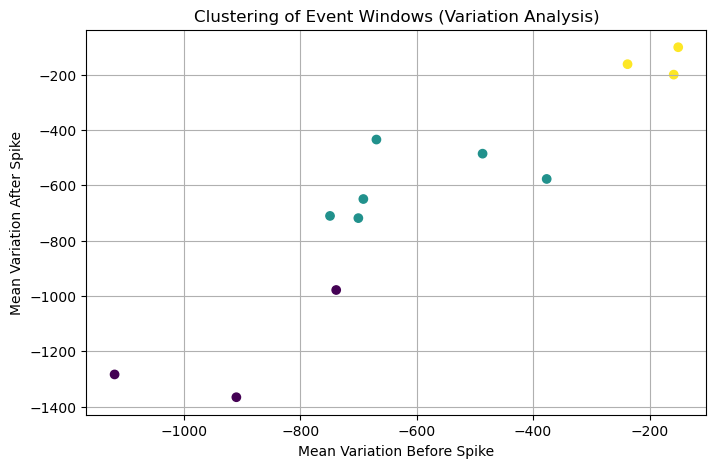

In [20]:
import os
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  # Optional for clustering

def read_windowed_csv(file_path):
    """
    Reads a CSV file containing multiple blocks of data (windows) separated by blank lines.
    Assumes that the header appears only once at the top of the file.
    Returns a list of DataFrames, each corresponding to one event window.
    """
    with open(file_path, 'r') as f:
        content = f.read().strip()
    
    # Split content into blocks based on blank lines
    blocks = [block.strip() for block in content.split('\n\n') if block.strip() != '']
    if not blocks:
        return []
    
    # Assume the first block contains the header and the first window.
    header_line = blocks[0].splitlines()[0]
    
    events = []
    for block in blocks:
        lines = block.splitlines()
        # If the block's first line does not match the header, prepend the header.
        if lines[0] != header_line:
            block = header_line + "\n" + block
        try:
            df_event = pd.read_csv(StringIO(block))
            events.append(df_event)
        except Exception as e:
            print("Error reading block, skipping it. Error:", e)
    return events

def compute_average_trajectory(events, column='variation'):
    """
    Given a list of event windows (each a DataFrame) and the name of the column to average,
    compute the average trajectory across events by grouping on the 'relative_position' column.
    """
    df_all = pd.concat(events, ignore_index=True)
    avg_traj = df_all.groupby('relative_position')[column].mean().reset_index()
    return avg_traj

def plot_average_trajectory(avg_traj, column='variation'):
    """
    Plots the average trajectory of the specified column (default: variation) 
    around the spike (aligned at relative_position = 0).
    """
    plt.figure(figsize=(8, 5))
    plt.plot(avg_traj['relative_position'], avg_traj[column], marker='o')
    plt.title("Average Trajectory of Variation Around Spike (relative_position aligned at 0)")
    plt.xlabel("Relative Position (0 = Spike Event)")
    plt.ylabel(f"Average {column.capitalize()}")
    plt.grid(True)
    plt.show()

# Optional: Extract features from each event window for clustering.
def extract_event_features(event_df, column='variation'):
    """
    Extract simple features from an event window:
      - The variation at the spike (relative_position == 0)
      - Mean variation before the spike
      - Mean variation after the spike
    Returns a pandas Series of features.
    """
    try:
        spike_value = event_df.loc[event_df['relative_position'] == 0, column].values[0]
    except IndexError:
        spike_value = np.nan
    before = event_df[event_df['relative_position'] < 0]
    after = event_df[event_df['relative_position'] > 0]
    mean_before = before[column].mean() if not before.empty else np.nan
    mean_after = after[column].mean() if not after.empty else np.nan
    return pd.Series({'spike_variation': spike_value, 'mean_before': mean_before, 'mean_after': mean_after})

def cluster_events(events, column='variation', n_clusters=2):
    """
    Optionally cluster the event windows based on extracted features from the specified column.
    Returns a DataFrame of features with cluster labels.
    """
    features_list = []
    for event in events:
        if 'relative_position' not in event.columns:
            print("Event window missing 'relative_position'. Skipping.")
            continue
        features = extract_event_features(event, column)
        if features.empty or features.isnull().any():
            print("Event window features incomplete. Skipping.")
            continue
        features_list.append(features)
    if not features_list:
        print("No valid event windows available for clustering.")
        return None
    features_df = pd.DataFrame(features_list)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_df)
    features_df['cluster'] = clusters
    return features_df

# ============================
# Example usage:
# ============================

# Set the path to one of your Variation CSV files.
# For example: Variation_Positive_secondary.csv, Variation_Negative_secondary.csv, etc.
file_path = 'Max_per_month/Variation_Positive_secondary.csv'  # Change as needed

# Read all event windows from the Variation CSV file.
event_windows = read_windowed_csv(file_path)
print(f"Read {len(event_windows)} event windows from {file_path}.")

# Compute the average trajectory of the 'variation' column.
avg_trajectory = compute_average_trajectory(event_windows, column='variation')
print("Average trajectory computed:")
print(avg_trajectory)

# Plot the average trajectory.
plot_average_trajectory(avg_trajectory, column='variation')

# Optional: Cluster the event windows based on features from the 'variation' column.
features_df = cluster_events(event_windows, column='variation', n_clusters=3)
if features_df is not None:
    print("Extracted features with cluster assignments:")
    print(features_df)
    
    # Optional: Visualize clustering results.
    plt.figure(figsize=(8, 5))
    plt.scatter(features_df['mean_before'], features_df['mean_after'], c=features_df['cluster'], cmap='viridis')
    plt.xlabel('Mean Variation Before Spike')
    plt.ylabel('Mean Variation After Spike')
    plt.title('Clustering of Event Windows (Variation Analysis)')
    plt.grid(True)
    plt.show()
